In [225]:
import sys
sys.path.append('../')
import pandas as pd
import gridworld_utils as util

import TreeWorld
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LogNorm, Normalize
from scipy import stats
from pathlib import Path
import pickle
import figures
from importlib import reload
import time

reload(util)
reload(figures)


<module 'figures' from '/home/rafal/L2projects/collaborative-intelligence/rafal_scribbles/../figures.py'>

In [226]:
grid =  util.create_2Dgrid(5)

print(grid)

(array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
       2, 3, 4]), array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24]))


In [227]:
util.loc1Dto2D(23, 5)

(3, 4)

In [228]:
N_sims = 2


## RU: so you run them multiple times, but every time with the same parameters?
## RU: for the paper it would be great to randomize them a bit

N_timesteps = 4
N_agents = 3
food_statistics_types = [
    "drop_food_once",
    "replenish_only_after_depleted",
    "regular_intervals",
    "poisson",
]
food_statistics_type = "drop_food_once"
N_food_units_total = 16
patch_dim = 2  # a patch has dimensions (patch_dim x patch_dim )
N_units_per_patch = patch_dim**2
N_patches = np.ceil(N_food_units_total / N_units_per_patch).astype(int)
calories_acquired_per_unit_time = 5  # when an agent is at a food location, it gains this many calories per time step
epoch_dur = (
    N_timesteps  # add new food in random locations every epoch_dur time steps
)

max_step_size = 2
sight_radius = 5
energy_init = 50
discount_factor = 0.9
c_food_self = 0.9
c_food_others = (
    0.1  # to what extent do the birds care about information from other birds?
)
c_otheragents = 0
c_group = 0
# c_predators = 0
c_weights = [c_food_self, c_food_others, c_otheragents, c_group]
caloric_cost_per_unit_dist = 1
doProbabilisticPolicy = True 
doSoftmaxPolicy = True
exploration_bias = 0.001


In [229]:
# Quantities to track
agent_locs_1d_allsims = np.zeros([N_sims, N_agents, N_timesteps])
dist_to_nearest_neighbor_allsims = np.zeros([N_sims, N_agents, N_timesteps])
calories_acquired_allsims = np.zeros([N_sims, N_agents, N_timesteps])
time_to_first_food_allsims = np.zeros([N_sims, N_agents])

print(agent_locs_1d_allsims.shape)
print(agent_locs_1d_allsims)

(2, 3, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


In [230]:
edge_size = 16 # grid world has dimensions edge_size x edge_size
x_arr, y_arr, loc_1d_arr = util.create_2Dgrid(edge_size)

print(x_arr)


# RU: note you can use order instead of transposing

print(
    np.reshape(x_arr, [edge_size, edge_size]).T
)

print(
    np.reshape(x_arr, [edge_size, edge_size], order='F')
)


print(y_arr)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7
  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7
  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7
  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7
  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7
  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3]
 [ 4  4  4  4  4

In [231]:
N_states = edge_size**2
T = np.zeros([N_states, N_states])

print(T)

#RU: note: once you have edge size = 1000 you may run into memory problems
#RU: MemoryError: Unable to allocate 7.28 TiB for an array with shape (1000000, 1000000) and data type float64

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [232]:
for i in range(N_states):
    for j in range(N_states):
        T[i, j] = (
            np.sqrt((x_arr[j] - x_arr[i]) ** 2 + (y_arr[j] - y_arr[i]) ** 2)
        ) <= max_step_size  # make this bigger to include more eligible states!!!

print(T)

# RU: this takes quite a bit of time already at edge_size = 150

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [233]:
print(np.sum(
    T, axis=0, keepdims=True
) 
)

T_eligible = T 
T_prob = T / np.sum(
    T, axis=0, keepdims=True
) 

# RU Why column-wise? 
# RU: did you intend to make pr proportional to from 
# RU: how many states you can go to it?

print(T_prob)

[[ 6.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  8.  6.  8. 11.
  12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 11.  8.  9. 12. 13. 13.
  13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 12.  9.  9. 12. 13. 13. 13. 13.
  13. 13. 13. 13. 13. 13. 13. 13. 12.  9.  9. 12. 13. 13. 13. 13. 13. 13.
  13. 13. 13. 13. 13. 13. 12.  9.  9. 12. 13. 13. 13. 13. 13. 13. 13. 13.
  13. 13. 13. 13. 12.  9.  9. 12. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.
  13. 13. 12.  9.  9. 12. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.
  12.  9.  9. 12. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 12.  9.
   9. 12. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 12.  9.  9. 12.
  13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 12.  9.  9. 12. 13. 13.
  13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 12.  9.  9. 12. 13. 13. 13. 13.
  13. 13. 13. 13. 13. 13. 13. 13. 12.  9.  9. 12. 13. 13. 13. 13. 13. 13.
  13. 13. 13. 13. 13. 13. 12.  9.  8. 11. 12. 12. 12. 12. 12. 12. 12. 12.
  12. 12. 12. 12. 11.  8.  6.  8.  9. 

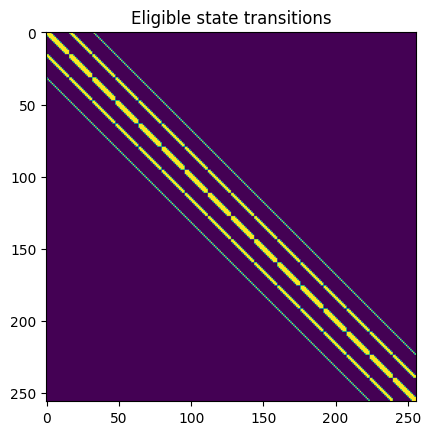

In [234]:
#RU: am I right in thinking that the discontinuities
#RU: in the heatmap are due to the fact that 
#RU  rows wrap around?

plt.figure()
plt.title("Eligible state transitions")
plt.imshow(T_eligible)


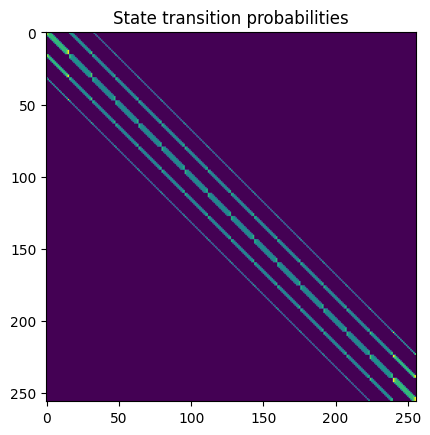

In [235]:
# RU: note you had T in the original

plt.figure()
plt.title("State transition probabilities")
plt.imshow(T_prob)  #here

# RU: why not make the probs a function of distance 

In [236]:
# for si in range(N_sims):

si = 0

phi_food = np.zeros(
    [N_states, 1]
)  # indicator vector showing which locations are occupied by food.

food_calories_by_loc = np.zeros(
    [N_states, 1]
) 

food_trajectory = np.zeros(
        [N_states, N_timesteps]
    )  # track food calories over time

print(food_trajectory)


food_init_loc_2d = np.reshape(phi_food, [edge_size, edge_size])

print(food_init_loc_2d)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [237]:
if food_statistics_type == "drop_food_once":
    for pi in range(N_patches):
        x_start = np.random.randint(0, edge_size - patch_dim)
        y_start = np.random.randint(0, edge_size - patch_dim)
        # generate (x,y) coordinates for each food unit in the patch
        x_range, y_range = np.arange(
            x_start, x_start + patch_dim
        ), np.arange(y_start, y_start + patch_dim)
        x_locs, y_locs = np.meshgrid(x_range, y_range, indexing="xy")
        # convert to 1D locations
        list_newfood_loc_1d = util.loc2Dto1D(
            x_locs.flatten(), y_locs.flatten(), edge_size
        )

        # update food tracking variables
        phi_food[list_newfood_loc_1d] = 1
        food_calories_by_loc[
            list_newfood_loc_1d
        ] = 20  # add a fixed number of calories to each new food location

    print(phi_food)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

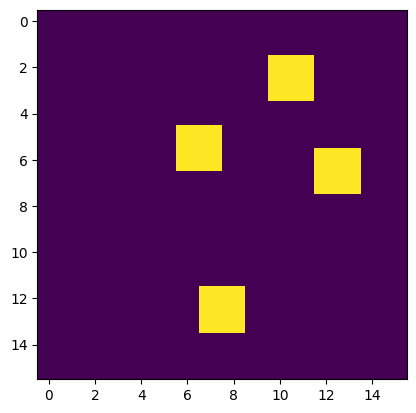

In [238]:
fig_env, ax_env = plt.subplots()
plt.imshow(food_init_loc_2d)

In [239]:
list_agents = []
loc_1d_allagents = np.zeros(
    N_agents, dtype=int
)  # array containing location of each agent (index is agent ID)
phi_agents = np.zeros(
[N_states, 1]
)

print(loc_1d_allagents)

print(phi_agents.shape)

# one-hot vector indicating how many agents are in each location (index is loc ID)

#RU: this seems derivable from other information, why do we need this?


calories_acquired_mat = np.zeros([N_agents, N_timesteps])
calories_expended_mat = np.zeros([N_agents, N_timesteps])
calories_total_mat = np.zeros([N_agents, N_timesteps])
calories_cumulative_vec = np.zeros([N_agents, N_timesteps])


[0 0 0]
(256, 1)


In [240]:
for ai in range(N_agents):
    new_agent = TreeWorld.SimpleAgent(
            T_prob,
            N_states,
            N_timesteps=N_timesteps,
            discount_factor=discount_factor,
            energy_init=energy_init,
            sight_radius=sight_radius,
        )
    list_agents.append(new_agent)

    current_loc_id = np.random.randint(N_states)  # pick a random location]
    new_agent.state_trajectory[0] = current_loc_id

    loc_1d_allagents[ai] = current_loc_id  # list
    phi_agents[current_loc_id] += 1  # add an agent to this location

print(loc_1d_allagents)

calories_total_mat[
        :, 0
    ] = energy_init  # each agent starts with 50 calories

[254  82  39]


In [253]:
    for ti in range(N_timesteps - 1):
        print("sim " + str(si) + ", time step " + str(ti))

        ## ---------------------Update environment----------------------------
        # features = phi_food# (N_features, N_states) matrix, each row being

        # Update agent calorie levels
        # food occupied by an agent decays over time
        # delta_food_calories_total = food_depletion_rate * food_calories_by_loc * phi_agents # only subtract food calories in locations occupied by agents, scaled by the number of agents
        delta_food_calories_total = (
            calories_acquired_per_unit_time * phi_agents
        )
        # rectify the calorie count for the food locations that will hit negative calories
        is_overdepleted = (
            delta_food_calories_total > food_calories_by_loc
        )  # find locations where the calorie count will hit negative values (we'll set the calorie count to 0)
        delta_food_calories_total[is_overdepleted] = food_calories_by_loc[
            is_overdepleted
        ]

        food_calories_by_loc -= delta_food_calories_total
        phi_food = (
            food_calories_by_loc > 0.01
        )  # update indicator  vector for food locations

        # if food_statistics_type == "replenish_after_depletion":
        #     if np.sum(food_calories_by_loc) <= 0:

        if food_statistics_type == "regular_intervals":
            # randomly add a new food patch every several time steps
            if ti % epoch_dur == 0:
                list_newfood_loc_id = np.random.permutation(
                    np.arange(N_states)
                )[:N_patches]
                phi_food[list_newfood_loc_id] = 1
                food_calories_by_loc[
                    list_newfood_loc_id
                ] = 20  # add a fixed number of calories to each new food location
                # TO DO: make phi_food a calorie count (randomly pick between a range of calories)

        # save food trajectory for plotting - how much food is in each location at each time step?
        food_trajectory[
            :, ti + 1
        ] = (
            food_calories_by_loc.flatten()
        )  # (N_states, N_timesteps)   # save as a sparse matrix?

        # update predator locations

        ## ---------------------Update agents ---------------------------------

        for ai, agent in enumerate(list_agents):
            # sum_weighted_features = agent.c.T @ features
            prev_loc_1d = int(
                agent.state_trajectory[ti]
            )  # agent's current location

            # ------ update energy consequences of previous time step's actions --------

            # update agent's total energy based on amount of food at previous location
            # transfer calories from food to agent
            calories_acquired_mat[ai, ti] = (
                delta_food_calories_total[prev_loc_1d]
                / phi_agents[prev_loc_1d][0]
            )[0]
            # RU: added [0] to ensure its a scalar; otherwise deprecation warning
            # RU: make sure that this is in line with your intentions
            
            #   # if there were N agents at that location, it gets 1/N portion of the calories
            agent.energy_total += calories_acquired_mat[ai, ti]
            calories_cumulative_vec[ai, ti + 1] = (
                calories_cumulative_vec[ai, ti] + calories_acquired_mat[ai, ti]
            )  # only tracks calories acquired?

            # # remove this agent from the list of surviving agents if it's energy reaches zero
            # if agent.energy_total <= 0:
            #     list_deceased_agents = list_surviving_agents.pop(ai)  # be careful b/c the rest of this for loop assumes all the agents are alive

            # -------------- Compute expected rewards, values, and make a decision --------------------------------

            phi_agents[prev_loc_1d] -= 1  # move out of previous location

            # EXPECTED REWARD RELATED TO OTHER AGENTS
            xloc_allagents, yloc_allagents = util.loc1Dto2D(
                loc_1d_allagents, edge_size
            )
            xloc_self, yloc_self = util.loc1Dto2D(prev_loc_1d, edge_size)
            # only include locations of agents outside of current location
            xloc_neighbors, yloc_neighbors = util.loc1Dto2D(
                loc_1d_allagents[loc_1d_allagents != prev_loc_1d], edge_size
            )

            # expected reward at each location based on proximity to other agents
            w_otheragents_2d = agent.reward_function_otheragents(
                xloc_neighbors, yloc_neighbors, xloc_self, yloc_self, edge_size
            )
            w_otheragents_1d = np.reshape(w_otheragents_2d, (N_states, 1))

            # EXPECTED REWARD RELATED TO CENTER OF MASS
            xloc_otheragents = np.delete(
                xloc_allagents, ai
            )  # remove this agent's own location from the list
            yloc_otheragents = np.delete(yloc_allagents, ai)  #
            if N_agents > 1:
                xloc_centerofmass, yloc_centerofmass = util.center_of_mass(
                    xloc_otheragents, yloc_otheragents
                )
            else:
                xloc_centerofmass, yloc_centerofmass = xloc_self, yloc_self

            # expected reward of each location based on this agent's distance from center of mass of the group
            w_groupcenterofmass = np.zeros([edge_size, edge_size])
            w_groupcenterofmass[
                int(yloc_centerofmass), int(xloc_centerofmass)
            ] = 0.5
            w_groupcenterofmass = np.reshape(
                w_groupcenterofmass, (N_states, 1)
            )
            
            # VISIBILITY CONSTRAINTS
            phi_visible_mat = agent.compute_visible_locations(
                xloc_self, yloc_self, edge_size
            )
            phi_visible = np.reshape(phi_visible_mat, (N_states, 1))


            #RU: let me make sure I understand: 
            #The info from other agents is just info about whether
            #there is food at their exact locations, 
            #not whether there is food within the other birds
            #visibility range, right?

            # get information from other agents about whether there is food at their locations
            # if doShareFoodInfo:
            #     phi_visible[loc_1d_allagents] = 1   # can this agent see the locations of other agents?
            # It's not quite communication between agents yet because there is no
            # capacity for misrepresentation here - the agent simply has information about other agent's locations.
            # The info from other agents should be represented separately from the agent's own information.
            # Then you can change communication parameters such as fidelity of info transmitted (add noise)

            # EXPECTED REWARD RELATED TO FOOD
            w_food = (
                phi_food * phi_visible
            )  # expected food reward at each location
            w_food_others = (
                phi_food * phi_agents
            )  # making food info from other agents a separate feature with separate weights

            sum_weighted_features = (
                c_weights[0] * w_food
                + c_weights[1] * w_food_others
                + c_weights[2] * w_otheragents_1d
                + c_weights[3] * w_groupcenterofmass
            )

            # sum_weighted_features = c_food_self * phi_food  + c_predator * phi_predator #+ c_otheragents * w_otheragents_1d

            # VALUE FUNCTION
            value = agent.SR @ sum_weighted_features  # (N_states, 1) vector

            # POLICY: select next action using the value and eligible states
            # eligible states are those specified by the transition matrix. Can constrain further to exclude states not occupied by other agents
            eligible_states_id = np.nonzero(T_eligible[:, prev_loc_1d])[
                0
            ]  # * np.logical_not(phi_agents.flatten()))[0]       # state IDs of eligible states
            value_eligible = value[
                eligible_states_id
            ].flatten()  # value of eligible states plus some noise

            # ACTION SELECTION

            if doProbabilisticPolicy:
                if doSoftmaxPolicy:
                    prob_arr = util.softmax(
                        value_eligible, temp=exploration_bias
                    )
                else:
                    # #sample eligible states from a categorical distribution whose shape is based on the values
                    # # convert values into probabilities
                    # value_eligible += 0.001 * np.random.randn(value_eligible.shape[0]) # add some noise
                    # prob_arr = value_eligible - np.min(value_eligible) # shift values so they are all positive and add some noise
                    prob_arr = value_eligible - np.min(value_eligible)
                    prob_arr += (
                        np.mean(value_eligible)
                        * 0.001
                        * np.random.rand(value_eligible.shape[0])
                    )
                    prob_arr = prob_arr / np.sum(
                        prob_arr
                    )  # normalize so they sum to 1

                next_loc_1d = np.random.choice(eligible_states_id, p=prob_arr)

            else:
                next_loc_1d = eligible_states_id[
                    np.argmax(value_eligible)
                ]  # DETERMINISTIC POLICY that works

            # ------- compute energy cost of moving to new location --------------

            xloc_prev, yloc_prev = util.loc1Dto2D(prev_loc_1d, edge_size)
            xloc_next, yloc_next = util.loc1Dto2D(next_loc_1d, edge_size)
            dist_traveled = np.sqrt(
                (xloc_next - xloc_prev) ** 2 + (yloc_next - yloc_prev) ** 2
            )
            calories_expended_mat[ai, ti] = (
                caloric_cost_per_unit_dist * dist_traveled
            )
            agent.energy_total -= calories_expended_mat[ai, ti]

            # ------------- compute metrics for data analysis -----------------
            if len(list_agents) > 1:
                dist_to_neighbors = np.sqrt(
                    (xloc_otheragents - xloc_self) ** 2
                    + (yloc_otheragents - yloc_self) ** 2
                )
                dist_to_nearest_neighbor_allsims[si, ai, ti] = np.min(
                    dist_to_neighbors
                )

            calories_acquired_allsims[si, ai, ti] = calories_acquired_mat[
                ai, ti
            ]

            if phi_food[next_loc_1d][0]:
                agent.times_at_food.append(
                    ti + 1
                )  # add this frame to the list of frames where agent is at a food location

            # -------------------------------------------------------------------

            agent.state_trajectory[ti + 1] = next_loc_1d  # scalar
            agent.value_trajectory[
                :, ti + 1
            ] = value.flatten()  # (N_states, N_timesteps)
            agent.energy_trajectory[ti + 1] = agent.energy_total
            calories_total_mat[ai, ti + 1] = (
                calories_total_mat[ai, ti]
                + calories_acquired_mat[ai, ti]
                - calories_expended_mat[ai, ti]
            )

            phi_agents[next_loc_1d] += 1  # move into new location
            loc_1d_allagents[ai] = next_loc_1d

    for ai, agent in enumerate(list_agents):
        # print(agent.times_at_food)
        if len(agent.times_at_food) == 0:
            time_to_first_food_allsims[
                si, ai
            ] = N_timesteps  # TO DO: figure out how to track agents who never reach food
        else:
            time_to_first_food_allsims[si, ai] = agent.times_at_food[
                0
            ]  # fetch the first time step where agent is at a food location



sim 0, time step 0
sim 0, time step 1
sim 0, time step 2


/tmp/ipykernel_4714/1311573623.py:63: RuntimeWarning: invalid value encountered in divide
  delta_food_calories_total[prev_loc_1d]


In [258]:
#RU: here we need to massage the data a bit

for ai, agent in enumerate(list_agents):
        print(agent.state_trajectory)
        #coords =  ..... agent.state_trajectory

print(food_trajectory)

[254. 252. 254. 254.]
[82. 84. 86. 87.]
[39. 41. 42. 58.]
[[  0. 225. 300. 375.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 ...
 [  0.   0.   0.   0.]
 [  0.   0.   5.   5.]
 [  0.   0.   0.   0.]]
